<a href="https://colab.research.google.com/github/gregorywmorris/MLZoom2022/blob/main/midterm/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Auto-save / Auto-reload
%autosave 1

%load_ext autoreload
%autoreload 2

Autosaving every 1 seconds


# Project Deliverables

**For a project, you repository/folder should contain the following:**

* `README.md` with
  * Description of the problem
  * Instructions on how to run the project
* Data
  * You should either commit the dataset you used or have clear instructions how to download the dataset
* Notebook (suggested name - `notebook.ipynb`) with
  * Data preparation and data clearning
  * EDA, feature importance analysis
  * Model selection process and parameter tuning
* Script train.py (suggested name)
  * Training the final model
  * Saving it to a file (e.g. pickle) or saving it with specialized software (BentoML)
* Script `predict.py` (suggested name)
  * Loading the model
  * Serving it via a web serice (with Flask or specialized sofware - BentoML, KServe, etc)
* Files with dependencies
  * `Pipenv` and `Pipenv.lock` if you use Pipenv
  * `bentofile.yaml` if you use BentoML
  * or equivalents: conda environment file, requirements.txt or pyproject.toml
* `Dockerfile` for running the service
* Deployment
  * URL to the service you deployed or
  * Video or image of how you interact with the deployed service





# !pip

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 2.2 MB/s 


In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install dask==2022.02.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install dataprep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 7.9 MB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 
     |████████████████████████████████| 1.0 MB 41.2 MB/s 
     |████████████████████████████████| 78 kB 3.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 133 kB 46.6 MB/s 
     |████████████████████████████████| 28.5 MB 157 kB/s 
     |████████████████████████████████| 50 kB 4.8 MB/s 
     |████████████████████████████████| 749 kB 36.2 MB/s 
     |████████████████████████████████| 943 kB 25.7 MB/s 
     |████████████████████████████████| 965 kB 21.5 MB/s 
     |████████████████████████████████| 96 kB 5.6 MB/s 
     |████████████████████████████████| 232 kB 53.8 MB/s 
     |████████████████████████████████| 1.6 MB 9.0 MB/s 
     |███████████████████████

# Imports

In [6]:
# for EDA
import pylab
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
import scipy
import scipy.sparse as sparse 
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as sla# needed for dataprep
from dataprep.eda import create_report

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt # https://scikit-plot.readthedocs.io/en/stable/Quickstart.htm

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import ComplementNB

# tuning and metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

# still need?
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


# Notebook Index

* [Problem Statement](#problem)
* [Data Selection](#data_about)
  * [Data Extraction](#extraction)
* [Exploritory Data Analysis (EDA)](#init_eda)
  * [Feature Importance (EDA)](#feat_imp)
* [Model Baseline](#baseline)
* [Tuning](#tuning)
  * [Feature Importance (model)](#model_fa)
* [Deployment](#deploy)

<a name="problem"></a>
# Why Predicting Stroke Likelihood Matters





### By the Numbers
**Global**

Strokes are a global epidemic. They are the second leading cause of death and have increased by 70% between 1990 to 2019, with death from strokes inceasing by 43% ([source](https://www.thelancet.com/journals/laneur/article/PIIS1474-4422(21)00252-0/fulltext)). The WHO estimates the anual cost of strokes to be over US$721 billion ([source](https://pubmed.ncbi.nlm.nih.gov/34986727/#:~:text=Abstract,%25%20of%20the%20global%20GDP)).

**United States**

While strokes have been declining for decades in the US, it still has a large financial burden, amounting to $53 billion anually ([source](https://www.cdc.gov/stroke/facts.htm)). Currently stroke is the 5th leading cause of death in the US ([source](https://www.cdc.gov/nchs/fastats/leading-causes-of-death.htm)).

### Optimal Outcomes
**Global**

Predicting stroke can provide an opportunity to take corrective actions before a stroke occurs. Most importantly, resulting in fewer deaths and disabilities.

Addtionally, the money lost to strokes would boost econamies. Assuming cost and stroke occurance are linear, if strokes were reduced by just 5%, that would inject $36 billion into world economies.

**United States**

And $2.65 billion into the US econamy.

<a name="about_data"></a>
# Stroke Data

### An Appropriate Dataset
A seach for various stroke datasets that included health factors showed that the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) was best suited. Numerous other stroke datasets are avaialbe but the lacked health factors needed. Datasets were often location based or even post stroke images. Neither are well suited for the the desired task.

### Limitations

* It is known that there are more factors for stroke prediction (such as [lab tests](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/), lifestyle, etc.) than are avaialble in this data set.
  * However, [the most important factors](https://www.sciencedirect.com/science/article/pii/S2772442522000090) are in the dataset
* This data set was uploaded 2 years ago with no expectations of being updated.
* The source and accuracy to the data is unkown, a verified healthcare organization would be an ideal source for stroke data.

# Extract-Load-Transform (ELT)


**Extract:** Data is extracted from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) to [GitHub](https://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csvhttps://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csv)

**Load:** Data is loaded to the notebook

**Transform:** Data is modified to suit and improve the model

#### Extract

Data: [GitHub](https://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csvhttps://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csv)

<a name="extraction"></a>
### Load

In [7]:
data = 'https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv'

In [8]:
!wget $data -O data.csv

--2022-11-02 17:29:17--  https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316971 (310K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 309.54K  --.-KB/s    in 0.03s   

2022-11-02 17:29:17 (9.86 MB/s) - ‘data.csv’ saved [316971/316971]



In [9]:
df = pd.read_csv('data.csv')

<a name="init_eda"></a>
### Transform - Exploritory Data Analysis (EDA)

##### [Dataprep](https://docs.dataprep.ai/user_guide/clean/introduction.html)

DataPrep Report
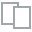
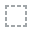
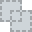
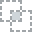
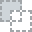
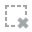
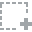
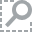
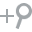
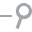
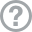
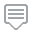
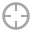
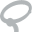
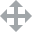
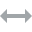
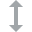
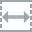
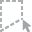
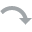
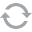
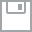
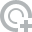
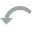
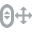
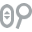
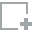
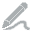
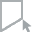
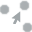
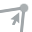
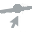

In [10]:
create_report(df)

**Report Summary:**
* bmi has 201 missing values
* No zero values (except where binary)
* Feature distributions are skewed
* Mix of numerical and catigorical features
* Low feature correlation

##### **Overview**

In [11]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [12]:
#@title Drop column 'id'
df = df.drop(columns='id')

In [13]:
#@title Column names are need to be normalized to all lower case
col = df.columns.tolist() # list with new column names all lower case
df = df.rename(str.lower, axis='columns')

In [14]:
#@title data Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [15]:
#@title statistical overview, look for outliers or oddities
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Min age of 0.08, expected whole integers.

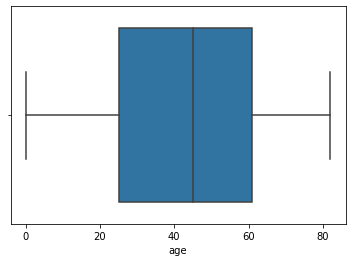

In [16]:
#@title No outliers in age
sns.boxplot(x=df.age)

In [17]:
#@title Distribution of all features are all highly possitivley skewed except for age which is slightly negatively skewed.
df.skew(numeric_only=True) # numeric_only=True else error

age                 -0.137059
hypertension         2.715392
heart_disease        3.947244
avg_glucose_level    1.572284
bmi                  1.055340
stroke               4.193284
dtype: float64

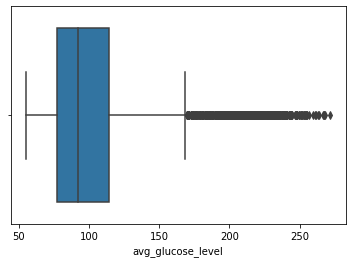

In [18]:
#@title Outliers noted in df.avg_glucose_level
sns.boxplot(x=df.avg_glucose_level)

In [19]:
df.avg_glucose_level.max()

271.74

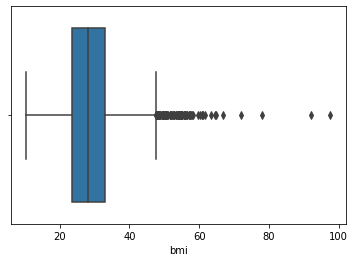

In [20]:
#@title Outliers noted in df.bmi
sns.boxplot(x=df.bmi)

In [21]:
df.bmi.max()

97.6

In [69]:
#@title This will be utilized for deep analysis
df_dummies = df.copy()

##### **Label Value - df.stroke**

The target value to be predicted is df.stroke. This a a binary feature with 1 to indicate possitive for stroke and 0 to indicate not possitive for stroke.

In [22]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

High imbalance with a low value count for the possitive prediction. 

The label data is imbalanced, this is consistent with expectations as more people don't have stroke than do. Further consideration should be done on the negative affect this may have on the models. [Possible solutions](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/).

##### **df.age**

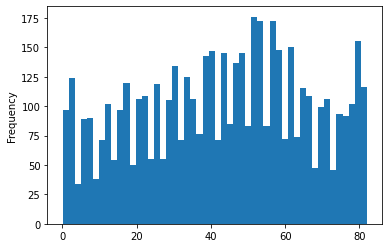

In [23]:
df.age.plot.hist(bins=50)

In [24]:
df.age.value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

Clarification on age [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/discussion/223242?search=age), decimal places represent days. 

##### **df.bmi**

###### **Missing values**
[Missing Value Guide](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/)
Fill missing values based on groups of either possitive for stroke or not. Suspect possible difference in grouping.

In [25]:
stroke_bmi_0, stroke_bmi_1 =df.groupby('stroke')['bmi'].mean()
stroke_bmi_0, stroke_bmi_1 # 0 not a stroke and 1 is a stroke

(28.823063829787234, 30.471291866028707)

In [26]:
round((stroke_bmi_1-stroke_bmi_0)/stroke_bmi_1,2)

0.05

Slight variance of 5% in bmi mean, note dtype is float64

Review the distribution of bmi as a total and by stroke value

((array([-3.6412931, -3.4063133, -3.2768215, ...,  3.2768215,  3.4063133,
          3.6412931]), array([10.3, 11.3, 11.5, ...,  nan,  nan,  nan])),
 (nan, nan, nan))

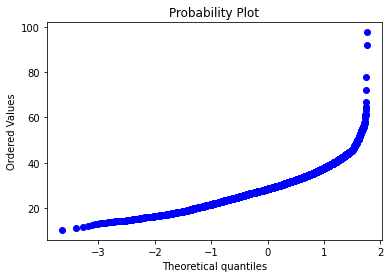

In [27]:
stats.probplot(df.bmi,fit=True, plot=pylab )

The probability plot shows that the bmi distribution is not normal. Next step is to see if the distribution can be transformed to a normal distribuion for a p-value analysis.

**Normalize df.bmi Distribution**

Distribution can be normalized well enough to calculate a p-value.

[Normalization techniques](https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/)

In [28]:
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

In [29]:
df_cp = df.copy() #must reimport data if this is ran after changes are made.

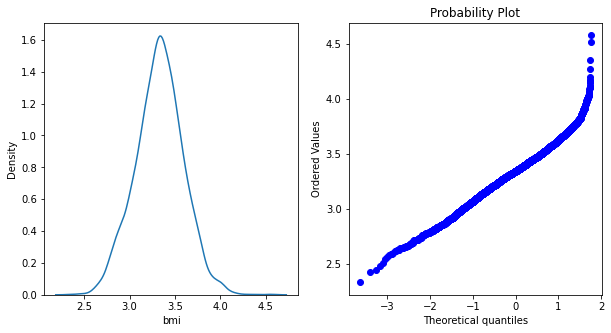

0.0011326087933981655

In [30]:
#performing logarithmic transformation on the feature
df_bmi = df_cp.copy()
df_bmi.bmi=np.log(df.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

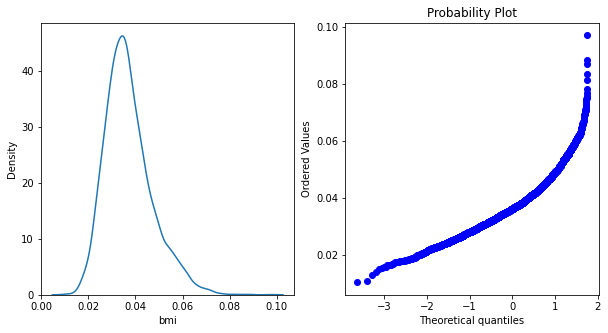

0.8591866889536662

In [31]:
#Reciprocal Transformation
df_bmi = df_cp.copy()
df_bmi.bmi=1/df_bmi.bmi
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

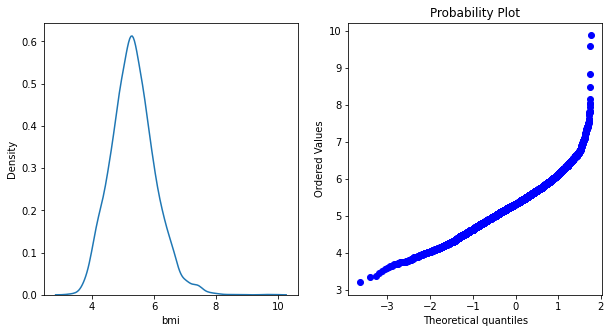

0.4748565689090631

In [32]:
#Square Root Transformation
df_bmi = df_cp.copy()
df_bmi.bmi=np.sqrt(df_bmi.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

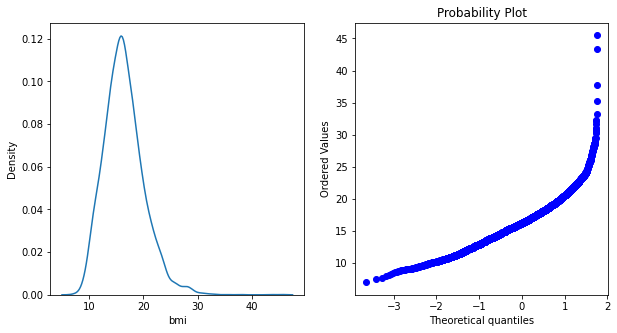

0.8439381127696062

In [33]:
#Exponential Transformation
df_bmi = df_cp.copy()
df_bmi.bmi=df.bmi**(1/1.2)
normality(df_bmi, 'bmi')
df_bmi.bmi.skew()

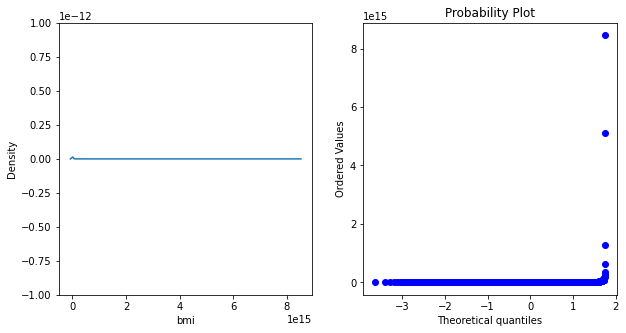

51.59532132895192

In [34]:
#Box-Cox Transformation
df_bmi = df_cp.copy()
df_bmi.bmi,parameters=stats.boxcox(df_bmi.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

**p-value**
The two sample test shows that the difference in the bmi distributions are NOT statistiacally signifigant. Replacing the missing values with the overall mean is justified.

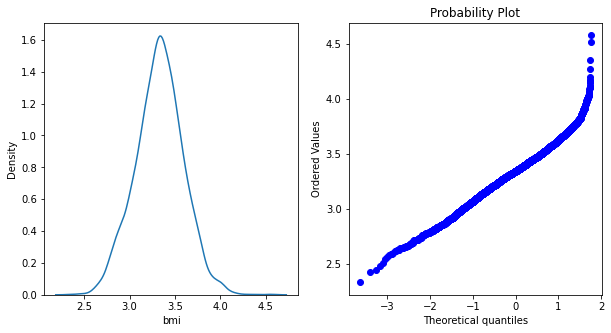

0.0011326087933981655

In [35]:
df_bmi = df.copy()
df_bmi.bmi=np.log(df.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

The distribution is very close to normal, only off by 0.001

stroke
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bmi, dtype: object

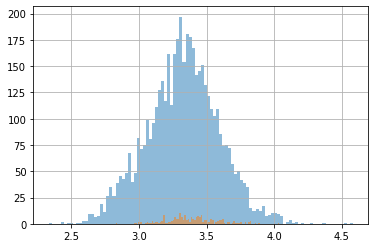

In [36]:
df_bmi.groupby('stroke')['bmi'].hist(bins=100, alpha=0.5)

In [37]:
bmi_stroke_0, bmi_stroke_1 =df_bmi.groupby('stroke')['bmi']

In [38]:
# one sample
stats.ttest_1samp(a=bmi_stroke_1[1],popmean=bmi_stroke_0[0], nan_policy='omit')

Ttest_1sampResult(statistic=244.833779465847, pvalue=6.025963176549174e-258)

The  one sample test shows that the difference in the bmi distributions are **NOT** statistiacally signifigant. Replacing the missing values with the overall median is justified. I chose median due the current outliers affecting the mean.

**Fill Missing Values**

In [39]:
df.bmi = df.bmi.fillna(df.bmi.median())

###### **Manage Outliers**

[Outliers Guide](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/) 

In [40]:
df.bmi.value_counts(bins=15).sort_values()

(80.14, 85.96]        0
(85.96, 91.78]        0
(68.5, 74.32]         1
(74.32, 80.14]        1
(91.78, 97.6]         2
(62.68, 68.5]         4
(56.86, 62.68]       13
(51.04, 56.86]       43
(45.22, 51.04]       86
(10.212, 16.12]     100
(39.4, 45.22]       299
(33.58, 39.4]       690
(16.12, 21.94]      774
(21.94, 27.76]     1501
(27.76, 33.58]     1596
Name: bmi, dtype: int64

Some outliers represent natural variations in the population, and they should be left as is in your dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

Without a height metric, these outliers are assumed to be natural variants in the population.

[BMI](https://www.cancer.org/healthy/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html)

###### **Obese Feature**

However, we do [know](https://www.cancer.org/healthy/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html) that people with a bmi of 30 or greater qualify as obese.

In [41]:
df['obese'] = df['bmi'] >=30

In [42]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,obese
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,True
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,False


In [43]:
df['obese'] = df['obese'].astype(int)
df['obese'].value_counts()

0    3190
1    1920
Name: obese, dtype: int64

##### **df.avg_glucose_level**

###### **P-value avg_glucose_level**

Reseach shows that Categorizing to above and below a bloodsugar limit may improve predictions.

 [Cleavland Clinic](https://my.clevelandclinic.org/health/diseases/9812-diabetes-and-stroke#:~:text=Your%20body%20can't%20make,Extra%20body%20weight.), [AHA Journal](https://www.ahajournals.org/doi/full/10.1161/01.str.0000115297.92132.84), [stroke.org.uk](https://www.stroke.org.uk/what-is-stroke/are-you-at-risk-of-stroke/diabetes), [Stroke.org - Diabetes](https://www.stroke.org/en/about-stroke/stroke-risk-factors/diabetes-and-stroke-prevention). 

In [44]:
stroke_glucose_0, stroke_glucose_1 =df.groupby('stroke')['avg_glucose_level'].mean()
stroke_glucose_0, stroke_glucose_1 # 0 not a stroke and 1 is a stroke

(104.79551326887471, 132.54473895582328)

In [45]:
round((stroke_glucose_1-stroke_glucose_0)/stroke_glucose_1,2)

0.21

A small variance in the mean of avg_glucose_level of 18%.

In [46]:
# stroke negative
stroke_gluc_0, stroke_gluc_1 =df.groupby('stroke')['avg_glucose_level']
stroke_gluc_0[1].describe()

count    4861.000000
mean      104.795513
std        43.846069
min        55.120000
25%        77.120000
50%        91.470000
75%       112.830000
max       267.760000
Name: avg_glucose_level, dtype: float64

In [47]:
# stroke possitive
stroke_gluc_1[1].describe()

count    249.000000
mean     132.544739
std       61.921056
min       56.110000
25%       79.790000
50%      105.220000
75%      196.710000
max      271.740000
Name: avg_glucose_level, dtype: float64

###### **Normallize avg_glucose_level**

((array([-3.6412931, -3.4063133, -3.2768215, ...,  3.2768215,  3.4063133,
          3.6412931]),
  array([ 55.12,  55.22,  55.23, ..., 267.61, 267.76, 271.74])),
 (40.678945925100635, 106.1476771037182, 0.8978160806829297))

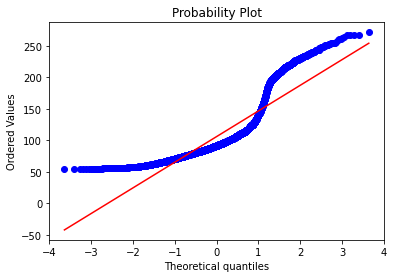

In [48]:
stats.probplot(df.avg_glucose_level,fit=True, plot=pylab )

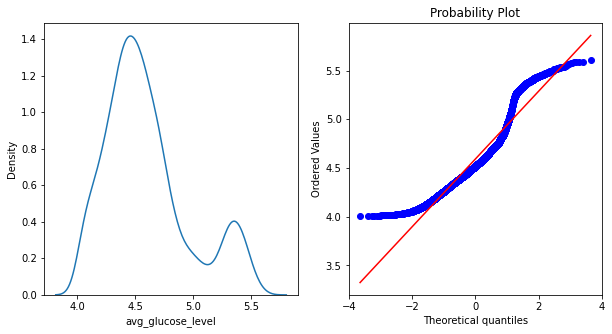

0.8827511014266456

In [49]:
#performing logarithmic transformation on the feature
df2 = df.copy()
df2.avg_glucose_level=np.log(df.avg_glucose_level)
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

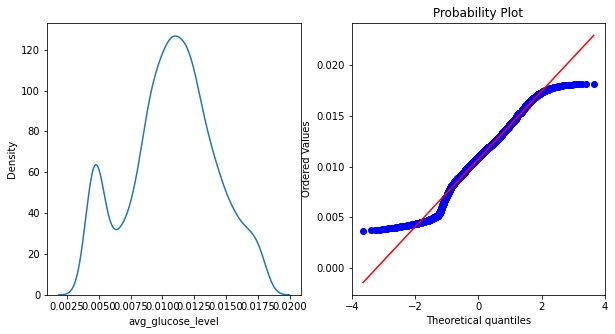

-0.12577378741588255

In [50]:
#Reciprocal Transformation
df2 = df_cp.copy()
df2.avg_glucose_level=1/df2.avg_glucose_level
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

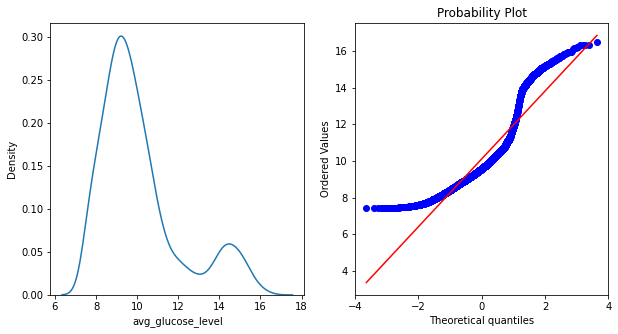

1.2427218676251186

In [51]:
#Square Root Transformation
df2 = df_cp.copy()
df2.avg_glucose_level=np.sqrt(df2.avg_glucose_level)
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

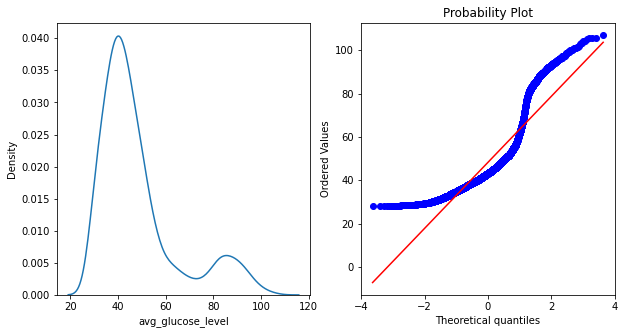

1.4662829646834146

In [52]:
#Exponential Transformation
df2 = df_cp.copy()
df2.avg_glucose_level=df.avg_glucose_level**(1/1.2)
normality(df2, 'avg_glucose_level')
df2.avg_glucose_level.skew()

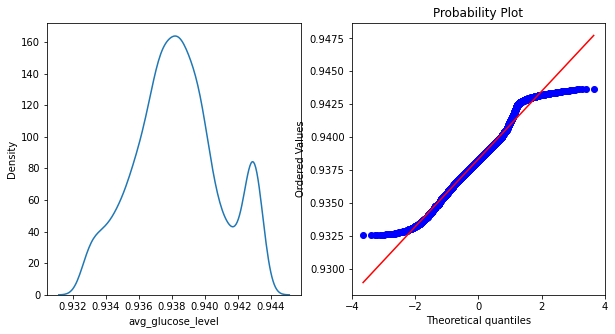

0.08329904162034814

In [53]:
#Box-Cox Transformation
df2 = df_cp.copy()
df2.avg_glucose_level,parameters=stats.boxcox(df2.avg_glucose_level)
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

###### **Final Decision**

* Unable to normalize the distribution avg_glucose_level
* Unable to get reliable p-value due to distribution

Despite research indicating a clear delineation with high blood sugar and stroke, I am not able to confirm that with the current understanding of the relationship from this data. No justification for categorizing avg_glucose_level based on reported glucose ranges should be done without further external reseach or more data.

###### **Outliers avg_glucose_level**

In [54]:
df['avg_glucose_level'].max()

271.74

In [55]:
df['avg_glucose_level'].min()

55.12

In [56]:
df.avg_glucose_level.value_counts(bins=15).sort_values()

(257.299, 271.74]       10
(242.857, 257.299]      35
(170.651, 185.092]      61
(156.209, 170.651]      71
(228.416, 242.857]      88
(141.768, 156.209]     113
(185.092, 199.533]     119
(213.975, 228.416]     145
(127.327, 141.768]     150
(199.533, 213.975]     162
(112.885, 127.327]     370
(54.902, 69.561]       728
(98.444, 112.885]      746
(84.003, 98.444]      1142
(69.561, 84.003]      1170
Name: avg_glucose_level, dtype: int64

Some outliers represent natural variations in the population, and they should be left as is in your dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

**Average glucose(a.k.a. blood sugar) level is measured though an A1C or HbA1c test.**

For a normal person blood sugar can get up to 140 per the [American Diabetes Association](https://diabetesjournals.org/care/article/24/4/775/23438/Postprandial-Blood-Glucose), but diabetes is diagnosed when **AVERAGE** blood sugar is 140 or higher. However, people with Diabetes can get much higher than on this data set. Without a diabetes diagnosis it is not possible to determine if the outliers are inaccurate data. However, it is possible to interpet those above 140 as clearly having diabetes.

Note, being below 140 does NOT signify someone does not have diabetes. They may simply be well controlled. Most type one diabetics aim for an average blood sugar of 140, while type two aim to be below that level.. 

###### **Clearly Diabetes**

In [57]:
df['clearly_diabetes'] = df['avg_glucose_level'] >= 140

In [58]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,obese,clearly_diabetes
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1,True
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,0,True
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1,False


In [59]:
df['clearly_diabetes'].replace({False: 0, True: 1}, inplace=True)
df['clearly_diabetes'].value_counts()

0    4289
1     821
Name: clearly_diabetes, dtype: int64

##### **df.residence_type**

In [61]:
df.residence_type.value_counts()

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

In [70]:
dummies = pd.get_dummies(df_dummies['residence_type'])
df_dummies = pd.concat([df_dummies, dummies],axis='columns')
del df_dummies['residence_type']
df_dummies.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke',
       'obese', 'clearly_diabetes', 'Rural', 'Urban'],
      dtype='object')

In [62]:
# intially converted to binary
#df.residence_type = (df.residence_type == 'Urban').astype(int)
#df.residence_type.value_counts()

##### **df.gender**

In [71]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

While sexual orientation is not binary, gender is considered binary. Being only one row, the best solution is to add it to the smaller data set. Resoning that the world population is nearly evenly split and the male population is under represented in this data set.

In [74]:
df.gender.replace('Other','Male', inplace=True)
df.gender.value_counts()

Female    2994
Male      2116
Name: gender, dtype: int64

In [75]:
dummies = pd.get_dummies(df_dummies.gender)
df_dummies = pd.concat([df_dummies, dummies],axis='columns')
del df_dummies['gender']
df_dummies.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'avg_glucose_level', 'bmi', 'smoking_status', 'stroke', 'obese',
       'clearly_diabetes', 'Rural', 'Urban', 'Female', 'Male', 'Other'],
      dtype='object')

In [76]:
# intially converted to binary
#df.gender = (df.gender == 'Female').astype(int)
#df.gender.value_counts()

##### **df.ever_married**

In [77]:
df.ever_married.value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [78]:
# convert Yes and No to 1 and 0.
df.ever_married = (df.ever_married == 'Yes').astype(int)
df.ever_married.value_counts()

1    3353
0    1757
Name: ever_married, dtype: int64

##### **df_dummies.work_type**

In [79]:
df_dummies.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [80]:
dummies = pd.get_dummies(df_dummies.work_type)
df_dummies = pd.concat([df_dummies, dummies],axis='columns')
del df_dummies['work_type']
df_dummies.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'smoking_status', 'stroke', 'obese',
       'clearly_diabetes', 'Rural', 'Urban', 'Female', 'Male', 'Other',
       'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
      dtype='object')

###### **df_dummies.smoking_status**

In [81]:
df_dummies.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [82]:
dummies = pd.get_dummies(df_dummies.smoking_status)
df_dummies = pd.concat([df_dummies, dummies],axis='columns')
del df_dummies['smoking_status']
df_dummies.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'stroke', 'obese', 'clearly_diabetes',
       'Rural', 'Urban', 'Female', 'Male', 'Other', 'Govt_job', 'Never_worked',
       'Private', 'Self-employed', 'children', 'Unknown', 'formerly smoked',
       'never smoked', 'smokes'],
      dtype='object')

##### **Final Feature Overview**

###### df_dummies

In [83]:
# convert new column names to lower
col = df_dummies.columns.tolist()
df_dummies = df_dummies.rename(str.lower, axis='columns')
col = df_dummies.columns.tolist() # list with new column names all lower case


In [84]:
# confirm column names and dtypes
df_dummies.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
avg_glucose_level    float64
bmi                  float64
stroke                 int64
obese                  int64
clearly_diabetes       int64
rural                  uint8
urban                  uint8
female                 uint8
male                   uint8
other                  uint8
govt_job               uint8
never_worked           uint8
private                uint8
self-employed          uint8
children               uint8
unknown                uint8
formerly smoked        uint8
never smoked           uint8
smokes                 uint8
dtype: object

Dummy columns may lose context once separated. Renaming columns would make the data more readable. Addionally the name word spacing should use '_' rather than ' ' or '-'.

In [85]:
df_dummies = df_dummies.rename(columns={'other': 'other_gender','formerly smoked':'formerly_smoked','never smoked':'never_smoked',
                                        'unknown':'unknown_smoking','children': 'is_a_child','private': 'employed',
                                        'self-employed':'self_employed' })

In [86]:
# Confirm changes
df_dummies.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
avg_glucose_level    float64
bmi                  float64
stroke                 int64
obese                  int64
clearly_diabetes       int64
rural                  uint8
urban                  uint8
female                 uint8
male                   uint8
other_gender           uint8
govt_job               uint8
never_worked           uint8
employed               uint8
self_employed          uint8
is_a_child             uint8
unknown_smoking        uint8
formerly_smoked        uint8
never_smoked           uint8
smokes                 uint8
dtype: object

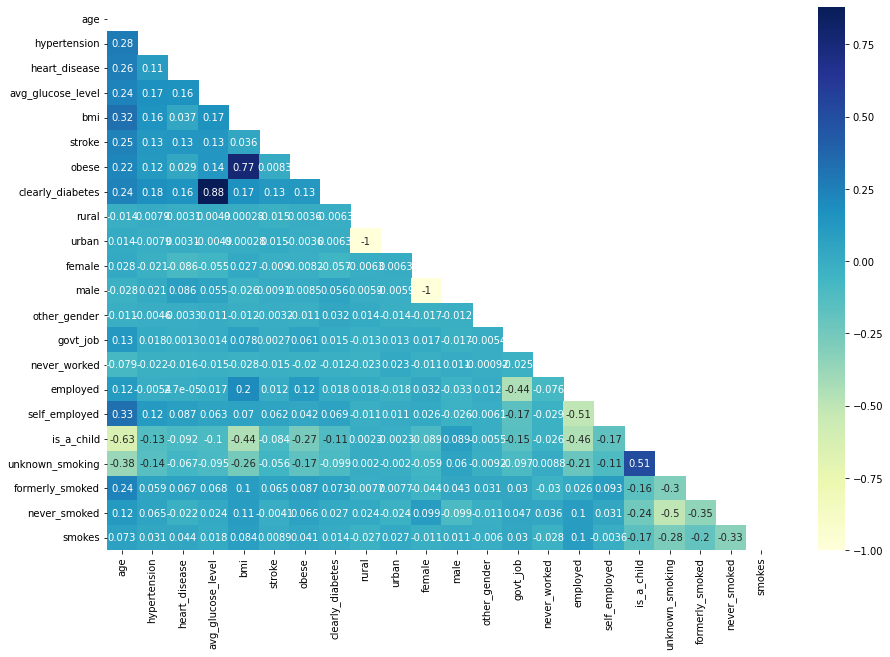

In [87]:
# Review feature correlation, consider action for highly correlated features.
plt.subplots(figsize=(15,10))

mask = np.triu(np.ones_like(df_dummies.corr())) # triangle mask to hide duplicates

sns.heatmap(df_dummies.corr(),cmap="YlGnBu", annot=True, mask=mask)

None of the **independant** features have a high (0.75+) correlation that may skew models. All feature have a low (< 0.50) to moderate (0.50 >< 0.75) correlation. 

Note: High correlation is acceptable for dependant features. The clearly_diabetes and obese columns are our only depenant columns.

In [88]:
df_dummies.skew().sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


other_gender         71.484264
never_worked         15.146344
stroke                4.193284
heart_disease         3.947244
hypertension          2.715392
govt_job              2.219958
is_a_child            2.143866
smokes                1.913452
self_employed         1.852619
clearly_diabetes      1.848660
formerly_smoked       1.727782
avg_glucose_level     1.572284
bmi                   1.088187
unknown_smoking       0.861974
never_smoked          0.537548
obese                 0.513317
male                  0.349749
rural                 0.032107
urban                -0.032107
age                  -0.137059
employed             -0.292800
female               -0.348930
dtype: float64

Much of the data is far from a Gaussian (normal) distribution. This will negatively affect model performance and is likely due to the sampling of data made avaiable on Kaggle. Consider [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer) and [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer).

<a name="feat_imp"></a>
##### **Feature Importance**

In [89]:
#@title Feature - stroke correlation
df_dummies.corr()['stroke'].sort_values(ascending=False).iloc[1:]

age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
clearly_diabetes     0.131171
hypertension         0.127904
formerly_smoked      0.064556
self_employed        0.062168
bmi                  0.036110
urban                0.015458
employed             0.011888
male                 0.009117
smokes               0.008939
obese                0.008337
govt_job             0.002677
other_gender        -0.003166
never_smoked        -0.004129
female              -0.009027
never_worked        -0.014882
rural               -0.015458
unknown_smoking     -0.055892
is_a_child          -0.083869
Name: stroke, dtype: float64

**Feature - stroke correlation:** the top independant feature `[age, heart_disease, avg_glucose_level, hypertension]` correlated features are consistent with expected relative to other correlations. 

**Unexpected:** That `ever_married` being slightly higher than `formerly_smoked`. Also, that `obese` is so much lower than `bmi` and practicly zero. Lastly, `clearly_diabetes` does not add any value. 

In [90]:
#@title df_dummies Drop the added features as they do not add to prediction

df_dummies.drop(['obese','clearly_diabetes'],axis='columns',inplace=True)
df_dummies.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'stroke', 'rural', 'urban', 'female',
       'male', 'other_gender', 'govt_job', 'never_worked', 'employed',
       'self_employed', 'is_a_child', 'unknown_smoking', 'formerly_smoked',
       'never_smoked', 'smokes'],
      dtype='object')

In [91]:
#@title df = Drop the added features as they do not add to prediction

df.drop(['obese','clearly_diabetes'],axis='columns',inplace=True)
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

<a name="baseline"></a>
# Modeling

The modeling proccess is to first test possable viable models, then select the best models, and create a baseline to compare the tuning process against. 

**Linear Regression** is a poor choice for clasification output problems and better suited for continuous output problems. While the label is binary the model could provide values outside of that range.

Researching ML models and the general concesses from ML engineers show the following models best for our label which is a binary classifier (stroke 1 or 0). There are numerous articles and research papers but this [article](https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6) and this [article](https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2) sum up the reasoning.

In [92]:
#@title def model_run(models)
def model_run(models):
  models_score = []
  for name, model in models:
      model = model
      model.fit(x_train, y_train)
      model.predict(x_test)
      models_score.append([name, accuracy_score(y_test, model.predict(x_test))])
      
      print(" ")
      print("Model: ",name)
      print('Testing Accuracy: ', accuracy_score(y_test, model.predict(x_test)))
      print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
      print(" ")
      
      plt.figure()
      cf_matrix = confusion_matrix(y_test, model.predict(x_test))
      plt.title('Confusion Matrix: {}'.format(name))
      sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
      plt.show()
      
      print(" ")

      skplt.metrics.plot_roc(y_test, model.predict_proba(x_test))
      plt.title('ROC Curves: {}'.format(name))
      plt.show()

### Data Prep

In [93]:
#@title Split: df_train / df_test

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.stroke.values
y_test = df_test.stroke.values

del df_train['stroke']
del df_test['stroke']

In [94]:
#@title x_train
train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dict)



In [95]:
#@title x_test
test_dict = df_test.to_dict(orient='records')
x_test = dv.transform(test_dict)

In [96]:
#@title def training_smote(x,y) - to address the stroke imbalance

# ONLY APPLY SMOTE TO TRAIN!
def training_smote(x,y):
    smt = SMOTE(random_state=1)
    x_train, y_train = smt.fit_resample(x, y)
    return x_train, y_train

In [97]:
x_train, y_train = training_smote(x_train, y_train)

### Model Comparison

In [98]:
#@title Model Selection
models = [('Logistic Regression', LogisticRegression(max_iter=1000,random_state=1)), # max_iter=1000 due to error
          ('Decision Tree Classifier', DecisionTreeClassifier(random_state=1)),
          ('Random Forest', RandomForestClassifier(random_state=1)),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          ('Ada Boost', AdaBoostClassifier(random_state=1)),
          ('KNN', KNeighborsClassifier()),
          ('Support Vector Machine', SVC(probability = True)),
          ('XG Boost Classifier', XGBClassifier(random_state=1)),
          ('Cat Boost', CatBoostClassifier(logging_level = 'Silent')),
          ('Naive Bayes', ComplementNB())]

 
Model:  Logistic Regression
Testing Accuracy:  0.7504892367906066
Training Accuracy:  0.767376250320595
 


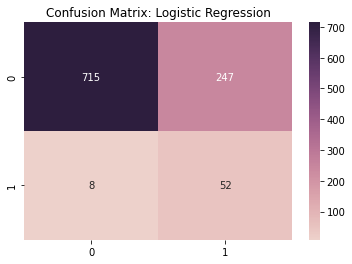

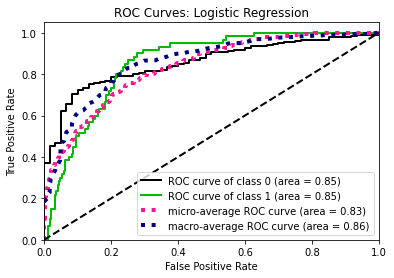

 
Model:  Decision Tree Classifier
Testing Accuracy:  0.8953033268101761
Training Accuracy:  1.0
 


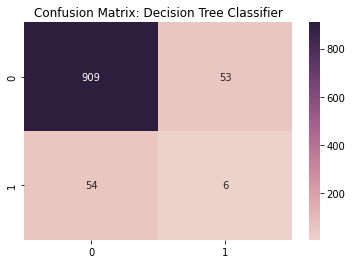

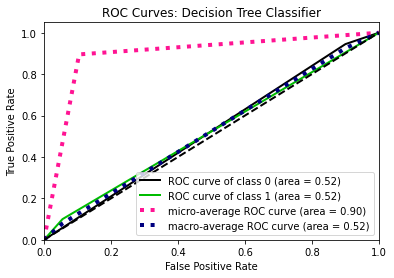

 
Model:  Random Forest
Testing Accuracy:  0.9344422700587084
Training Accuracy:  1.0
 


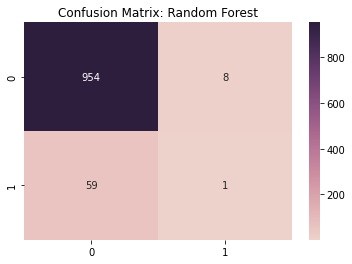

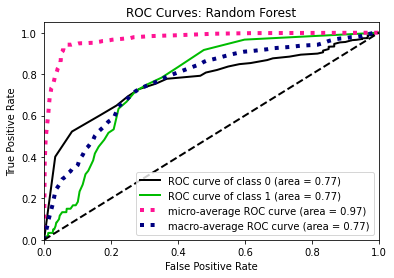

 
Model:  Linear Discriminant Analyzer
Testing Accuracy:  0.7455968688845401
Training Accuracy:  0.7704539625545012
 


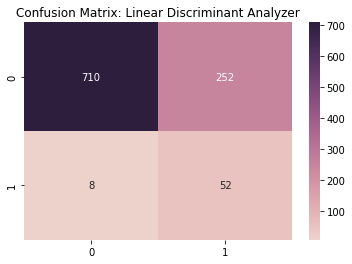

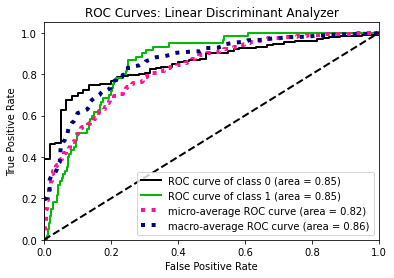

 
Model:  Ada Boost
Testing Accuracy:  0.9295499021526419
Training Accuracy:  0.9620415491151577
 


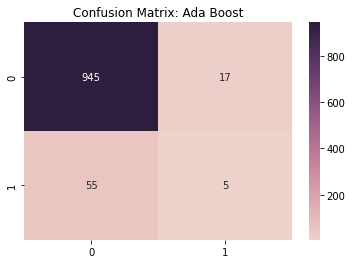

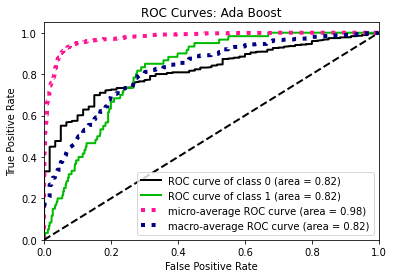

 
Model:  KNN
Testing Accuracy:  0.7857142857142857
Training Accuracy:  0.9184406258014876
 


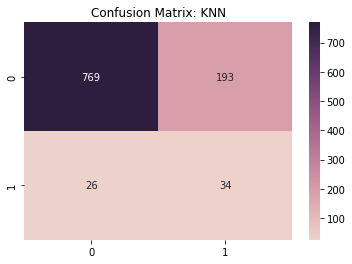

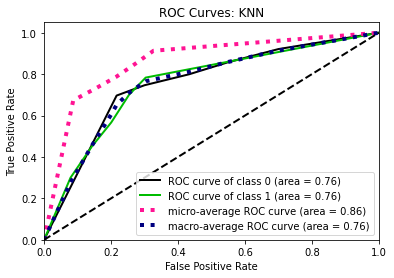

 
Model:  Support Vector Machine
Testing Accuracy:  0.7221135029354208
Training Accuracy:  0.7562195434726853
 


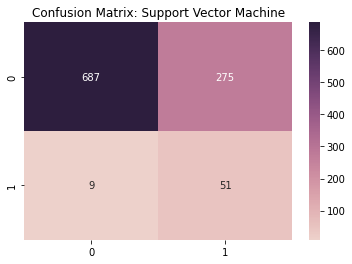

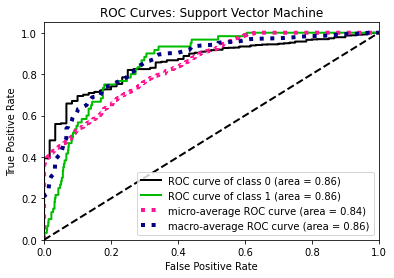

 
Model:  XG Boost Classifier
Testing Accuracy:  0.9403131115459883
Training Accuracy:  0.973967684021544
 


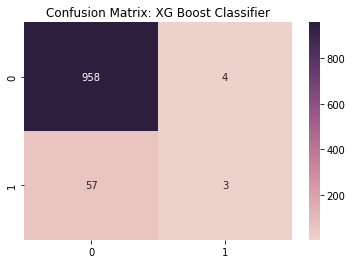

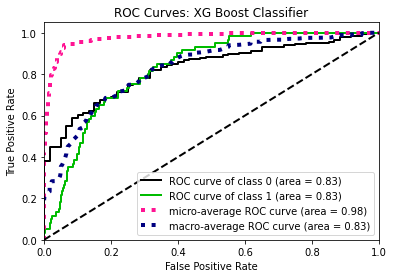

 
Model:  Cat Boost
Testing Accuracy:  0.9285714285714286
Training Accuracy:  0.9910233393177738
 


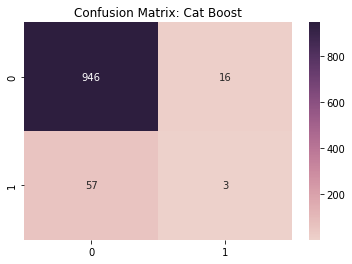

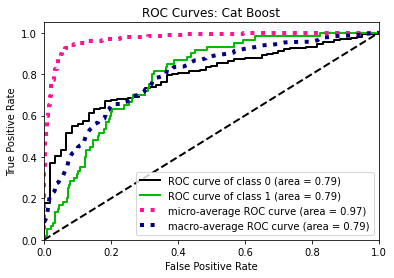

 
Model:  Naive Bayes
Testing Accuracy:  0.6555772994129159
Training Accuracy:  0.6982559630674532
 


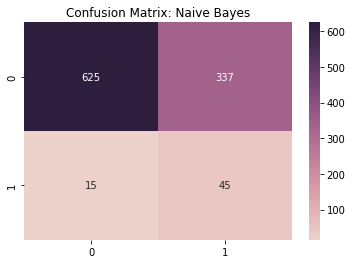

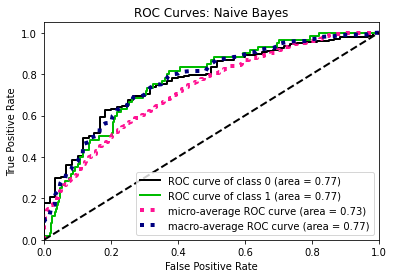

In [99]:
#@title Run all models
model_run(models)

Regarding [convergence error](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter)

### Best Performing Models

**While the score may not be the highest, these models were the best at predicting a stroke. The trade off is lower non-stroke accuracy. In the case of healthcare, we would rather capture non-stroke than miss actual strokes.**

In [100]:
#@title Selected Models
selected_models = [('Logistic Regression', LogisticRegression(max_iter=1000, random_state=1)),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis())]

 
Model:  Logistic Regression
Testing Accuracy:  0.7504892367906066
Training Accuracy:  0.767376250320595
 


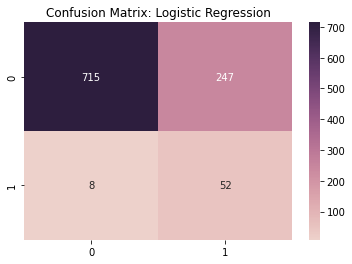

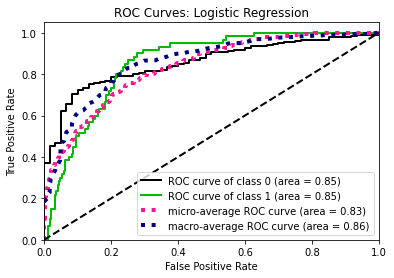

 
Model:  Linear Discriminant Analyzer
Testing Accuracy:  0.7455968688845401
Training Accuracy:  0.7704539625545012
 


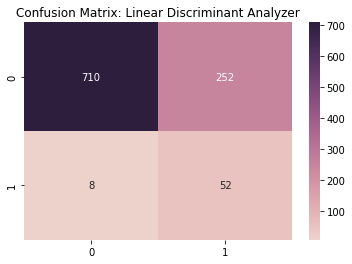

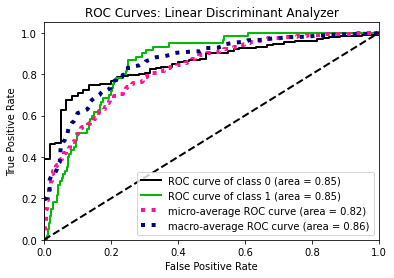

In [101]:
model_run(selected_models)

<a name="tuning"></a>
# Tuning

The tuning process consists of adjusting and measuring model parameters, and, if needed, revisiting feature engineering.

**Best Preforming Model**

Both selected models did equally well with ~0.75 and ~0.77 for testing and training accuracy respectively. Logistic regression predicted non-stroke slighlty better.

**Overview**

Comparison of the models in the variable `selected_models`:

* **Logistic Regression**, `LogisticRegression()`
  * *Testing Accuracy:  0.7485322896281801*
  * *Training Accuracy:  0.7677609643498333*
* **Linear Discriminant Analyzer**, `LinearDiscriminantAnalysis()`
  * *Testing Accuracy:  0.738747553816047*
  * *Training Accuracy:  0.7686586304180559*

<a name="model_fa"></a>
## Model Feature Importance - [article](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

In [111]:
#@title Split: df_train / df_test

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.stroke.values
y_test = df_test.stroke.values

del df_train['stroke']
del df_test['stroke']

In [112]:
X = df_train
y = y_train

In [113]:
x_dict = X.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X = dv.fit_transform(x_dict)

In [114]:
my_list = [LogisticRegression(max_iter=1000, random_state=1),LinearDiscriminantAnalysis()]

In [115]:
#@title Feature Rank
for model in my_list:
    rfe = RFECV(estimator=model,step=1,cv=5)
    rfe.fit(X,y)
    print(" ")
    print(model)
    print(" ")
    for j, col, in zip(range(df.shape[1]), df.columns):
      print(f'{col} selected= {rfe.support_[1]} rank= {rfe.ranking_[1]}')

 
LogisticRegression(max_iter=1000, random_state=1)
 
gender selected= False rank= 7
age selected= False rank= 7
hypertension selected= False rank= 7
heart_disease selected= False rank= 7
ever_married selected= False rank= 7
work_type selected= False rank= 7
residence_type selected= False rank= 7
avg_glucose_level selected= False rank= 7
bmi selected= False rank= 7
smoking_status selected= False rank= 7
stroke selected= False rank= 7
 
LinearDiscriminantAnalysis()
 
gender selected= False rank= 18
age selected= False rank= 18
hypertension selected= False rank= 18
heart_disease selected= False rank= 18
ever_married selected= False rank= 18
work_type selected= False rank= 18
residence_type selected= False rank= 18
avg_glucose_level selected= False rank= 18
bmi selected= False rank= 18
smoking_status selected= False rank= 18
stroke selected= False rank= 18


Independantly, none of the features rank high on importance for stroke prediction for the selected models. This would indicate that it is certain combinations of the features that are required to predict stroke.

In [107]:
#@title Get Feature Names
feat_names = dv.get_feature_names_out()

In [116]:
#@title def feature_importance(model)
def feature_importance(model):
    # define the model
    model = model
    # fit the model
    model.fit(X, y)
    # get importance
    importance = model.coef_[0]
    # summarize feature importance
    for i,v in enumerate(importance):
        print(f'Feature: {feat_names[i]}',' ',f'Score: {v}\n')

In [117]:
#@title Logistic Feature coefficients

feature_importance(LogisticRegression(max_iter=1000, random_state=1))

Feature: age   Score: 0.07341970142888116

Feature: avg_glucose_level   Score: 0.0037093455526170447

Feature: bmi   Score: 0.0001233046790549353

Feature: ever_married   Score: -0.4454385311939315

Feature: gender=Female   Score: 0.07813702082909114

Feature: gender=Male   Score: -0.06757200044272466

Feature: heart_disease   Score: 0.29063318589018866

Feature: hypertension   Score: 0.410997091411181

Feature: residence_type=Rural   Score: -0.05012146713782063

Feature: residence_type=Urban   Score: 0.06068648752807439

Feature: smoking_status=Unknown   Score: 0.016629773275897902

Feature: smoking_status=formerly smoked   Score: 0.043796353734615566

Feature: smoking_status=never smoked   Score: -0.07856100152082839

Feature: smoking_status=smokes   Score: 0.028699894901171894

Feature: work_type=Govt_job   Score: -0.14227302246131293

Feature: work_type=Never_worked   Score: -0.0871645199984022

Feature: work_type=Private   Score: 0.10592388747438378

Feature: work_type=Self-employ

In [118]:
#@title Linear Discriminant Feature coefficients

feature_importance(LinearDiscriminantAnalysis())
   
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.show()

Feature: age   Score: 0.07688208232854707

Feature: avg_glucose_level   Score: 0.0059009222820991065

Feature: bmi   Score: -0.01466738231904265

Feature: ever_married   Score: -1.0743641273930642

Feature: gender=Female   Score: 0.11309347081365663

Feature: gender=Male   Score: -0.1130934708136563

Feature: heart_disease   Score: 1.2004120458791667

Feature: hypertension   Score: 0.9639119218704704

Feature: residence_type=Rural   Score: -0.08217806406940599

Feature: residence_type=Urban   Score: 0.08217806406940617

Feature: smoking_status=Unknown   Score: 0.092040927482527

Feature: smoking_status=formerly smoked   Score: 0.016317939884555103

Feature: smoking_status=never smoked   Score: -0.043749817769469734

Feature: smoking_status=smokes   Score: -0.08985865354311114

Feature: work_type=Govt_job   Score: -0.4408267749833068

Feature: work_type=Never_worked   Score: 0.37660263713267783

Feature: work_type=Private   Score: -0.003740652599861774

Feature: work_type=Self-employed 

**Model Feature Importance**


In [110]:
#@title Of note is the strong possitive coefficients for work_type=children. However, it is known that stroke in children is  [rare](https://www.hopkinsmedicine.org/health/conditions-and-diseases/stroke/pediatric-stroke#:~:text=Pediatric%20stroke%20is%20a%20rare,blood%20vessel%20(cerebrovascular)%20disord).
df[df.work_type == 'children'].stroke.value_counts()

0    685
1      2
Name: stroke, dtype: int64

<a name="deploy"></a>
# Deployment